# Predicting Click
## Data Exploration, Visualization, Modeling

Ryan Koch - AMLI 2019 Mills College
- ryanwkoch@gmail.com 

Note to self:
#### Data analysis
1. Look at columns, graph out variance of columns (min/max) .describe
    * Document output of .describe for each column
2. Understand which column are finite vs. continuous values
 - encode subcategories of categorical columns
 - graph out frequency of values
3. Scatter plot to find outliers
- hypothesize about data (what I can feed to our models) 
4. Find best application of random forest on raw data (try PCA + OHE, Boosting, etc.)
5. Run neural net on cleaned data 
6. Repeat, tune model parameters, manipulate data, reapeat until desired performance is achieved.


#### Experiment with different models on cleaned data
1. Start small — try one model with one feature to predict click
    * Run NN on one feature to predict click
    * Then try other features, etc.
2. Test out many different models
    * SGD descent classifier
    * Document the output of each model and compare with baseline
        Things to try with more time: 
        * Make a graph (the width of the network vs. depth network vs. loss of network) 
        * Describe a line through time that shows how tuning different hyper parameters effects the model (automated data discovery)
        * Document everything — ask questions like:
            * When does the model start overfitting?
            * What happens if my neural net has 100 neurons? 10? compare.
            * Try five layers deep vs. One
            * In each comparison, was there any value? Is there a point of diminishing return?
            * Try adding more / different GPUs, etc.

#### Informed feature engineering: 
* note to teammates: avoid feature engineering unless we have domain knowledge of the features — let the models do the work, emphasize normalizing/standardizing data and controlling/understanding column variance to get better model performance FIRST.

We can feature engineer things like 'banners', we see ad banners every day, try this:
1. Use K-Means on ads — find natural divisions in banners 
2. Try to find clusters of information around ads
3. Make classes for clusters of ads (i.e., square ads, long rectangular banners, etc.)
    * Make scatterplots of the heights, widths of ad banners/size
    * Turn those into one column — make ordinal ’types’ of banners

Subdivide by website — see if we can be more predictive based on the destination site_id, etc.
* Encode unique groups of hashed values of site_id column (one hot encoder)
* Then test, we can discover that maybe “site_a” provides a higher accuracy and so on. 

*Don’t need recurrent neural net or a convolutional neural net — Josh recommends a basic neural net. Prof. James Intriligator recommends PCA to reduce dimensionality of data.

### References
 - CTR: https://towardsdatascience.com/mobile-ads-click-through-rate-ctr-prediction-44fdac40c6ff
 - bagging/boosting: https://quantdare.com/what-is-the-difference-between-bagging-and-boosting/
 - PCA: 
 https://towardsdatascience.com/principal-component-analysis-ceb42ed04d77
 https://towardsdatascience.com/a-one-stop-shop-for-principal-component-analysis-5582fb7e0a9c
 - onehotencoding:
 https://hackernoon.com/what-is-one-hot-encoding-why-and-when-do-you-have-to-use-it-e3c6186d008f
 - OHE, LE vs DV:
 https://datascience.stackexchange.com/questions/9443/when-to-use-one-hot-encoding-vs-labelencoder-vs-dictvectorizor
  - the sage wisdom of AMLI instructors, TAs and others
 

## Import Libraries and Data

In [1]:
import pandas as pd
import numpy as np
import multiprocessing as mp
import psutil
import random
import datetime as datetime
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [4]:
# read in the Avazu - criteo labs - csv file
# rand_sample_csv is a randomized subset (1% the size) of the sample_csv which is ~400k instances 

df = pd.read_csv('data-rand_sample_eng.csv')


# Data Exploration

In [7]:
# peep the raw data
df.head(5)

,Unnamed: 0,id,click,hour,C1,banner_pos,site_id,site_domain,site_category,app_id,...,C15,C16,C17,C18,C19,C20,C21,new_date,new_time,day_of_week
0,0,10004510652136496837,0,14102100,1005,0,543a539e,c7ca3108,3e814130,ecad2386,...,320,50,2333,0,39,-1,157,2014-10-21,00:00:00,1
1,1,10007164336863914220,1,14102100,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,...,320,50,1722,0,35,-1,79,2014-10-21,00:00:00,1
2,2,10076859283156800622,0,14102100,1002,0,f17ebd97,c4e18dd6,50e219e0,ecad2386,...,216,36,2497,3,43,100151,42,2014-10-21,00:00:00,1
3,3,10078825124049580646,0,14102100,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,...,320,50,1722,0,35,-1,79,2014-10-21,00:00:00,1
4,4,10085233430943183912,0,14102100,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,...,320,50,1722,0,35,-1,79,2014-10-21,00:00:00,1


In [8]:
df.describe()

,Unnamed: 0,id,click,hour,C1,banner_pos,device_type,device_conn_type,C14,C15,C16,C17,C18,C19,C20,C21,day_of_week
count,404410.000000,4.044100e+05,404410.000000,4.044100e+05,404410.000000,404410.000000,404410.000000,404410.000000,404410.000000,404410.000000,404410.000000,404410.000000,404410.000000,404410.000000,404410.000000,404410.000000,404410.000000
mean,202204.500000,9.213896e+18,0.169991,1.410256e+07,1004.967372,0.288638,1.014695,0.331688,18844.936193,318.795856,60.076581,2112.733881,1.431426,227.891140,53239.462209,83.304955,2.601259
std,116743.255518,5.319411e+18,0.375625,2.968127e+02,1.090207,0.504033,0.523959,0.855877,4947.526554,20.667022,47.023691,607.929983,1.325359,351.686105,49955.391770,70.251537,1.727362
min,0.000000,7.306813e+13,0.000000,1.410210e+07,1001.000000,0.000000,0.000000,0.000000,375.000000,120.000000,20.000000,112.000000,0.000000,33.000000,-1.000000,1.000000,0.000000
25%,101102.250000,4.607240e+18,0.000000,1.410230e+07,1005.000000,0.000000,1.000000,0.000000,16920.000000,320.000000,50.000000,1863.000000,0.000000,35.000000,-1.000000,23.000000,1.000000
50%,202204.500000,9.218443e+18,0.000000,1.410260e+07,1005.000000,0.000000,1.000000,0.000000,20346.000000,320.000000,50.000000,2323.000000,2.000000,39.000000,100048.000000,61.000000,2.000000
75%,303306.750000,1.382200e+19,0.000000,1.410281e+07,1005.000000,1.000000,1.000000,0.000000,21893.000000,320.000000,50.000000,2526.000000,3.000000,171.000000,100086.000000,101.000000,4.000000
max,404409.000000,1.844673e+19,1.000000,1.410302e+07,1012.000000,7.000000,5.000000,5.000000,24043.000000,1024.000000,1024.000000,2757.000000,3.000000,1839.000000,100248.000000,255.000000,6.000000


In [10]:
df.shape # this sample has 404,410 rows of data with 28 columns

(404410, 28)

In [13]:
df.dtypes # avazu: "all integer features are categorical variables, all IDs, no numerical meaning"

Unnamed: 0           int64
id                  uint64
click                int64
hour                 int64
C1                   int64
banner_pos           int64
site_id             object
site_domain         object
site_category       object
app_id              object
app_domain          object
app_category        object
device_id           object
device_ip           object
device_model        object
device_type          int64
device_conn_type     int64
C14                  int64
C15                  int64
C16                  int64
C17                  int64
C18                  int64
C19                  int64
C20                  int64
C21                  int64
new_date            object
new_time            object
day_of_week          int64
dtype: object

In [15]:
# what do is known about the columns?

 - id: ad identifier
 - click: 0/1 for non-click/click
 - hour: format is YYMMDDHH
 - C1 — anonymized categorical variable
 - banner_pos
 - site_id
 - site_domain
 - site_category
 - app_id
 - app_domain
 - app_category
 - device_id
 - device_ip
 - device_model
 - device_type
 - device_conn_type
 - C14-C21 — anonymized categorical variables

# Data Preprocessing

In [18]:
# 'Unnamed: 0', 'Unnamed: 0.1' are row indexes which were tansposed into columns. 
# Aint nobody got time for that.
# Drop those puppies.
df_new = df.drop(['Unnamed: 0'], axis=1) 

In [19]:
df_new.shape

(404410, 27)

In [20]:
# check for missing values
df_new.isnull().sum()


id                  0
click               0
hour                0
C1                  0
banner_pos          0
site_id             0
site_domain         0
site_category       0
app_id              0
app_domain          0
app_category        0
device_id           0
device_ip           0
device_model        0
device_type         0
device_conn_type    0
C14                 0
C15                 0
C16                 0
C17                 0
C18                 0
C19                 0
C20                 0
C21                 0
new_date            0
new_time            0
day_of_week         0
dtype: int64

In [22]:
# summed list of each column for df_new
# getting a feel for column variance
for col in df_new.columns.values:
    total = len(df_new[col].unique())
    print(str(col) + " " + "total: " + str(total))

id total: 404410
click total: 2
hour total: 240
C1 total: 7
banner_pos total: 7
site_id total: 2195
site_domain total: 2172
site_category total: 21
app_id total: 2305
app_domain total: 153
app_category total: 26
device_id total: 64913
device_ip total: 262453
device_model total: 4369
device_type total: 5
device_conn_type total: 4
C14 total: 2067
C15 total: 8
C16 total: 9
C17 total: 415
C18 total: 4
C19 total: 65
C20 total: 159
C21 total: 60
new_date total: 10
new_time total: 24
day_of_week total: 7


Each instance of a column are hashed values of an original ID.
Hashing was done to anonymize the services contributing ad data of this dataset.
For illustrative/descriptive purposes we will treat each hashed value as names or in other fictional contexts (e.g.,'7801e8d9' = 'www.overstock.com'). (Thank you to Naomi for explaining the hashed value confusion)

# Feature Engineering
## Hour & Date 

In [23]:
# check hour column data type
df_new.hour.dtype

dtype('int64')

In [25]:
# separate the date and time
parse_date = lambda val : pd.datetime.strptime(val, '%y%m%d%H')
df_new['new_hour'] = df_new.hour.astype(str).apply(parse_date)
df_new['new_hour']

0        2014-10-21 00:00:00
1        2014-10-21 00:00:00
2        2014-10-21 00:00:00
3        2014-10-21 00:00:00
4        2014-10-21 00:00:00
5        2014-10-21 00:00:00
6        2014-10-21 00:00:00
7        2014-10-21 00:00:00
8        2014-10-21 00:00:00
9        2014-10-21 00:00:00
10       2014-10-21 00:00:00
11       2014-10-21 00:00:00
12       2014-10-21 00:00:00
13       2014-10-21 00:00:00
14       2014-10-21 00:00:00
15       2014-10-21 00:00:00
16       2014-10-21 00:00:00
17       2014-10-21 00:00:00
18       2014-10-21 00:00:00
19       2014-10-21 00:00:00
20       2014-10-21 00:00:00
21       2014-10-21 00:00:00
22       2014-10-21 00:00:00
23       2014-10-21 00:00:00
24       2014-10-21 00:00:00
25       2014-10-21 00:00:00
26       2014-10-21 00:00:00
27       2014-10-21 00:00:00
28       2014-10-21 00:00:00
29       2014-10-21 00:00:00
                 ...        
404380   2014-10-30 23:00:00
404381   2014-10-30 23:00:00
404382   2014-10-30 23:00:00
404383   2014-

In [33]:
# check if column 'new_hour' was created and parsed
df_new.head(3)

,id,click,hour,C1,banner_pos,site_id,site_domain,site_category,app_id,app_domain,...,C16,C17,C18,C19,C20,C21,new_date,new_time,day_of_week,new_hour
0,10004510652136496837,0,14102100,1005,0,543a539e,c7ca3108,3e814130,ecad2386,7801e8d9,...,50,2333,0,39,-1,157,2014-10-21,00:00:00,1,2014-10-21
1,10007164336863914220,1,14102100,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,...,50,1722,0,35,-1,79,2014-10-21,00:00:00,1,2014-10-21
2,10076859283156800622,0,14102100,1002,0,f17ebd97,c4e18dd6,50e219e0,ecad2386,7801e8d9,...,36,2497,3,43,100151,42,2014-10-21,00:00:00,1,2014-10-21


In [34]:
#confirm dtype of new_hour
df_new.new_hour.dtype

dtype('<M8[ns]')

In [35]:
# create new_date & new_time columns from parsed new_hour column
df_new['date'] = [d.date() for d in df_new['new_hour']]
df_new['time'] = [d.time() for d in df_new['new_hour']]

In [36]:
#check if columns were established properly
df_new.head(3)

,id,click,hour,C1,banner_pos,site_id,site_domain,site_category,app_id,app_domain,...,C18,C19,C20,C21,new_date,new_time,day_of_week,new_hour,date,time
0,10004510652136496837,0,14102100,1005,0,543a539e,c7ca3108,3e814130,ecad2386,7801e8d9,...,0,39,-1,157,2014-10-21,00:00:00,1,2014-10-21,2014-10-21,00:00:00
1,10007164336863914220,1,14102100,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,...,0,35,-1,79,2014-10-21,00:00:00,1,2014-10-21,2014-10-21,00:00:00
2,10076859283156800622,0,14102100,1002,0,f17ebd97,c4e18dd6,50e219e0,ecad2386,7801e8d9,...,3,43,100151,42,2014-10-21,00:00:00,1,2014-10-21,2014-10-21,00:00:00


In [37]:
df_new.dtypes # check data types again

id                          uint64
click                        int64
hour                         int64
C1                           int64
banner_pos                   int64
site_id                     object
site_domain                 object
site_category               object
app_id                      object
app_domain                  object
app_category                object
device_id                   object
device_ip                   object
device_model                object
device_type                  int64
device_conn_type             int64
C14                          int64
C15                          int64
C16                          int64
C17                          int64
C18                          int64
C19                          int64
C20                          int64
C21                          int64
new_date                    object
new_time                    object
day_of_week                  int64
new_hour            datetime64[ns]
date                

In [38]:
# drop redundant cols
df_tmp = df_new.drop(['new_hour', 'hour'], axis=1)

In [41]:
#Find the start and end date of the dataset
print(df_tmp['date'].min(), df_tmp['date'].max())

2014-10-21 2014-10-30


Our dataset ranges from 10/21/2014 to 10/30/2014. It spans a total of 10 days.

In [40]:
df_tmp.head(2)

,id,click,C1,banner_pos,site_id,site_domain,site_category,app_id,app_domain,app_category,...,C17,C18,C19,C20,C21,new_date,new_time,day_of_week,date,time
0,10004510652136496837,0,1005,0,543a539e,c7ca3108,3e814130,ecad2386,7801e8d9,07d7df22,...,2333,0,39,-1,157,2014-10-21,00:00:00,1,2014-10-21,00:00:00
1,10007164336863914220,1,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,07d7df22,...,1722,0,35,-1,79,2014-10-21,00:00:00,1,2014-10-21,00:00:00


In [42]:
# sannity check: lets look at those summed unique vals again
for col in df_tmp.columns.values:
    total = len(df_tmp[col].unique())
    val = df_tmp[col].unique()
    print(str(col) + " " + "total: " + str(total))

id total: 404410
click total: 2
C1 total: 7
banner_pos total: 7
site_id total: 2195
site_domain total: 2172
site_category total: 21
app_id total: 2305
app_domain total: 153
app_category total: 26
device_id total: 64913
device_ip total: 262453
device_model total: 4369
device_type total: 5
device_conn_type total: 4
C14 total: 2067
C15 total: 8
C16 total: 9
C17 total: 415
C18 total: 4
C19 total: 65
C20 total: 159
C21 total: 60
new_date total: 10
new_time total: 24
day_of_week total: 7
date total: 10
time total: 24


# Feature Engineering Continued
### device_type converted into binary columns by device_type encoding 


In [43]:
# iterate through columns and print the unique values of each column
for col in df_tmp.columns.values:
    val = df_tmp[col].unique()
    print(str(col) + " " + ", val: " + str(val))

id , val: [10004510652136496837 10007164336863914220 10076859283156800622 ...
  9930625418032326788  9953588061726377330  9959058523366506236]
click , val: [0 1]
C1 , val: [1005 1002 1010 1007 1008 1012 1001]
banner_pos , val: [0 1 2 5 7 4 3]
site_id , val: ['543a539e' '1fbe01fe' 'f17ebd97' ... '9fd919ea' '1b72ccd8' '5a51436e']
site_domain , val: ['c7ca3108' 'f3845767' 'c4e18dd6' ... '0da06afc' '3e87e1c9' '645c06d3']
site_category , val: ['3e814130' '28905ebd' '50e219e0' '76b2941d' 'f028772b' 'f66779e6'
 '0569f928' '335d28a8' '72722551' '75fa27f6' 'c0dd3be3' 'a818d37a'
 '8fd0aea4' '70fb0e29' 'dedf689d' 'e787de0e' '5378d028' 'bcf865d9'
 '42a36e14' '9ccfa2ea' 'c706e647']
app_id , val: ['ecad2386' '1779deee' 'febd1138' ... '96f19b66' '5717fe5d' '404b2054']
app_domain , val: ['7801e8d9' '2347f47a' '82e27996' '45a51db4' '5c5a694b' 'afdf1f54'
 'aefc06bd' 'ae637522' 'd9b5648e' '828da833' '5b9c592b' '0654b444'
 '885c7f3f' 'b8d325c3' 'b5f3b24a' 'ad63ec9b' '33da2e74' '43cf4f06'
 '15ec7f39' '18eb

In [44]:
# use device_type as practice. There are 5 unique vals -- smaller numbers are easier to work with
df_tmp.device_type.nunique()

5

In [45]:
# store df_tmp.device_type as var for ease of re-use
dvc_type = df_tmp.device_type

In [46]:
# check instance of dvc_type
dvc_type[0]

1

In [47]:
# val counts gives me the count of each unique values 
dvc_type.value_counts()

1    373412
0     22074
4      7676
5      1247
2         1
Name: device_type, dtype: int64

In [48]:
# make var to hold col 'names' based off unique values stored as a list
col_names = df_tmp['device_type'].unique().tolist()
col_names


[1, 0, 4, 5, 2]

In [49]:
# check it
df_tmp.head(3)

,id,click,C1,banner_pos,site_id,site_domain,site_category,app_id,app_domain,app_category,...,C17,C18,C19,C20,C21,new_date,new_time,day_of_week,date,time
0,10004510652136496837,0,1005,0,543a539e,c7ca3108,3e814130,ecad2386,7801e8d9,07d7df22,...,2333,0,39,-1,157,2014-10-21,00:00:00,1,2014-10-21,00:00:00
1,10007164336863914220,1,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,07d7df22,...,1722,0,35,-1,79,2014-10-21,00:00:00,1,2014-10-21,00:00:00
2,10076859283156800622,0,1002,0,f17ebd97,c4e18dd6,50e219e0,ecad2386,7801e8d9,07d7df22,...,2497,3,43,100151,42,2014-10-21,00:00:00,1,2014-10-21,00:00:00


In [50]:
# look at df of cols to check stats on encodings
df_tmp[col_names] = pd.get_dummies(df_tmp['device_type'])
df_tmp[col_names].describe()

,1,0,4,5,2
count,404410.000000,404410.000000,404410.000000,404410.000000,404410.000000
mean,0.054583,0.923350,0.000002,0.018981,0.003084
std,0.227165,0.266036,0.001572,0.136457,0.055444
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,0.000000,0.000000,0.000000
50%,0.000000,1.000000,0.000000,0.000000,0.000000
75%,0.000000,1.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000


In [52]:
# 2 unique numbers for column 1 - confirming binary vals
df_tmp[col_names][1].nunique()

2

In [53]:
# check for missing values -- there are none, good.
df_tmp.isnull().sum()

id                  0
click               0
C1                  0
banner_pos          0
site_id             0
site_domain         0
site_category       0
app_id              0
app_domain          0
app_category        0
device_id           0
device_ip           0
device_model        0
device_type         0
device_conn_type    0
C14                 0
C15                 0
C16                 0
C17                 0
C18                 0
C19                 0
C20                 0
C21                 0
new_date            0
new_time            0
day_of_week         0
date                0
time                0
1                   0
0                   0
4                   0
5                   0
2                   0
dtype: int64

In [56]:
# now last few rows are columns stratified by device type -- experimenting with manual encoding and blowing out cols
df_tmp.shape


(404410, 33)

In [59]:
# peep last 5 cols -- device types, just gota know 
df_tmp[df_tmp.columns[-5:]].head(3)

,1,0,4,5,2
0,0,1,0,0,0
1,0,1,0,0,0
2,1,0,0,0,0


In [62]:
# rename device_type col name for readability / understanding
df_dvtype = df_tmp
df_dvtype = df_dvtype.rename({1:'device_type_a',0:'device_type_b',4:'device_type_c',5:'device_type_d', 2:'device_type_e'}, axis='columns')
df_dvtype.columns

Index(['id', 'click', 'C1', 'banner_pos', 'site_id', 'site_domain',
       'site_category', 'app_id', 'app_domain', 'app_category', 'device_id',
       'device_ip', 'device_model', 'device_type', 'device_conn_type', 'C14',
       'C15', 'C16', 'C17', 'C18', 'C19', 'C20', 'C21', 'new_date', 'new_time',
       'day_of_week', 'date', 'time', 'device_type_a', 'device_type_b',
       'device_type_c', 'device_type_d', 'device_type_e'],
      dtype='object')

In [63]:
df_num = df_dvtype.drop(columns = ['id', 'new_time', 'new_date'])

In [72]:
df_num.columns
df_num.shape # cool - removed id', 'new_time', 'new_date' cols, practicing data elimination

(404410, 30)

### Change dtypes to Numeric
our models looove numeric vals 

In [74]:
# converting non-numerical columns into numerical columns
categories = ['site_id', 'site_domain','site_category', 'app_id', 'app_domain', 'app_category', 'device_id', 'device_ip', 'device_model', 'date', 'time']

for category in categories:
  df_num[category] = df_num[category].astype('category').cat.codes

In [77]:
# check dtypes
df_num.dtypes # great success! 

click               int64
C1                  int64
banner_pos          int64
site_id             int16
site_domain         int16
site_category        int8
app_id              int16
app_domain          int16
app_category         int8
device_id           int32
device_ip           int32
device_model        int16
device_type         int64
device_conn_type    int64
C14                 int64
C15                 int64
C16                 int64
C17                 int64
C18                 int64
C19                 int64
C20                 int64
C21                 int64
day_of_week         int64
date                 int8
time                 int8
device_type_a       uint8
device_type_b       uint8
device_type_c       uint8
device_type_d       uint8
device_type_e       uint8
dtype: object

In [76]:
df_num.head(3)
df_num.tail(3)

,click,C1,banner_pos,site_id,site_domain,site_category,app_id,app_domain,app_category,device_id,...,C20,C21,day_of_week,date,time,device_type_a,device_type_b,device_type_c,device_type_d,device_type_e
404407,0,1005,0,263,2056,1,2129,65,0,43137,...,-1,51,3,9,23,0,1,0,0,0
404408,0,1005,0,1145,1680,5,1396,17,24,43137,...,-1,221,3,9,23,0,1,0,0,0
404409,0,1005,0,263,2056,1,2129,65,0,43137,...,-1,51,3,9,23,0,1,0,0,0


In [78]:
df_num.device_id.nunique()

64913

In [79]:
df_tmp.device_id.nunique()

64913

In [80]:
# just checking d.o.w. -- day_of_week is good; date is numbered 0-9 as there are 10 days of data
df_num.day_of_week.describe()

count    404410.000000
mean          2.601259
std           1.727362
min           0.000000
25%           1.000000
50%           2.000000
75%           4.000000
max           6.000000
Name: day_of_week, dtype: float64

# Original features
This is what the dataset looked like before tinkering with it

 - Target feature : click
 - Site features : site_id, site_domain, site_category
 - App feature: app_id, app_domain, app_category
 - Device feature: device_id, device_ip, device_model, device_type, device_conn_type
 - Anonymized categorical features: C14-C21

# New Features
This is what the dataset looks like after tinkering with it

#### All features are numerical (df_num)
- Target feature : click
 - Site features : site_id, site_domain, site_category
 - App feature: app_id, app_domain, app_category
 - Device feature: device_id[a,b,c,d,e], device_ip, device_model, device_type, device_conn_type[a,b,c,d,e]
 - Anonymized numerical features: C14-C21
 - user (sam added user cols - this is reflected in 'choice_features.csv'

# Data Analysis


In [81]:
df_da = df_num

In [82]:
df_da.head(3)

,click,C1,banner_pos,site_id,site_domain,site_category,app_id,app_domain,app_category,device_id,...,C20,C21,day_of_week,date,time,device_type_a,device_type_b,device_type_c,device_type_d,device_type_e
0,0,1005,0,755,1712,3,2129,65,0,43137,...,-1,157,1,0,0,0,1,0,0,0
1,1,1005,0,263,2056,1,2129,65,0,43137,...,-1,79,1,0,0,0,1,0,0,0
2,0,1002,0,2052,1680,5,2129,65,0,30034,...,100151,42,1,0,0,1,0,0,0,0


## Clicks

0 = no click, 1 = click

In [87]:
df_da.click.value_counts()/len(df_da.click) # the majority of our clicks are non-clicks (false negatives)

0    0.830009
1    0.169991
Name: click, dtype: float64

In [91]:
# encode these categories - setting up to control variance & add context to groups of unique vals
col_nams_ohe = []

for col in df_num.columns.values:
    total = len(df_num[col].unique())
    val = df_num[col].unique()
    if total < 26 and total > 2:
        col_nams_ohe.append(col)
        print(str(col) + " " + "has: " + str(total) + " sub-categories")

C1 has: 7 sub-categories
banner_pos has: 7 sub-categories
site_category has: 21 sub-categories
device_type has: 5 sub-categories
device_conn_type has: 4 sub-categories
C15 has: 8 sub-categories
C16 has: 9 sub-categories
C18 has: 4 sub-categories
day_of_week has: 7 sub-categories
date has: 10 sub-categories
time has: 24 sub-categories


### One hot encoder: automated encoding for sub-categories of columns

In [105]:
# categorical cols 'C1','banner_pos','site_category','device_type','device_conn_type','C15','C16','C18'
# experimenting with one hot encoder...

from numpy import array
from numpy import argmax
from keras.utils import to_categorical

#data = array(df_num['device_conn_type'])
#print(data)

practice_df = pd.Series(data)
practice_df.to_frame(name='data')
practice_df = practice_df.rename(columns= {0: 'list'}).rename_axis('practice_target').reset_index(name='practice_cols')
#practice_df.index.name = 'index'
practice_df

# one hot encode
encoded = to_categorical(practice_df['practice_cols'])
print(encoded)
# invert encoding
#inverted = argmax(encoded)
#print(inverted)

[[1. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0.]
 [0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0. 0. 0.]]


In [106]:
# only works if you flatten the ndarray
encoded = encoded.flatten()
encoded

array([1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0.],
      dtype=float32)

In [107]:
pd.get_dummies(encoded).describe()

,0.0,1.0
count,133.000000,133.000000
mean,0.857143,0.142857
std,0.351250,0.351250
min,0.000000,0.000000
25%,1.000000,0.000000
50%,1.000000,0.000000
75%,1.000000,0.000000
max,1.000000,1.000000


In [114]:
practice_df.describe()

,practice_target,practice_cols
count,19.000000,19.000000
mean,9.000000,3.263158
std,5.627314,1.939132
min,0.000000,0.000000
25%,4.500000,2.000000
50%,9.000000,3.000000
75%,13.500000,5.000000
max,18.000000,6.000000


To stick to our (4 week gantt chart) timeline - we had to discontinue OHE and continue onto experimenting with other methods

### A Closer Look at 'device_conn_type'

In [131]:
df_num['device_type'].describe()

count    404410.000000
mean          1.014695
std           0.523959
min           0.000000
25%           1.000000
50%           1.000000
75%           1.000000
max           5.000000
Name: device_type, dtype: float64

In [132]:
col_nams_ohe = col_nams_ohe[0:8]
col_nams_ohe

['C1',
 'banner_pos',
 'site_category',
 'device_type',
 'device_conn_type',
 'C15',
 'C16',
 'C18']

In [134]:
df_num['device_conn_type'].unique().tolist()

[0, 2, 3, 5]

In [136]:
# make var to hold col 'names' based off unique values stored in a list
dct_col_names = df_num['device_conn_type'].unique().tolist()
dct_col_names
df_num[dct_col_names] = pd.get_dummies(df_num['device_conn_type'])
df_num.head(3)

,click,C1,banner_pos,site_id,site_domain,site_category,app_id,app_domain,app_category,device_id,...,time,device_type_a,device_type_b,device_type_c,device_type_d,device_type_e,0,2,3,5
0,0,1005,0,755,1712,3,2129,65,0,43137,...,0,0,1,0,0,0,1,0,0,0
1,1,1005,0,263,2056,1,2129,65,0,43137,...,0,0,1,0,0,0,1,0,0,0
2,0,1002,0,2052,1680,5,2129,65,0,30034,...,0,1,0,0,0,0,1,0,0,0


In [138]:
df_dv_conn_type = df_num.rename({0:'device_conn_type_a',2:'device_conn_type_b',3:'device_conn_type_c',5:'device_conn_type_d'}, axis='columns')
df_dv_conn_type.head(3)

,click,C1,banner_pos,site_id,site_domain,site_category,app_id,app_domain,app_category,device_id,...,time,device_type_a,device_type_b,device_type_c,device_type_d,device_type_e,device_conn_type_a,device_conn_type_b,device_conn_type_c,device_conn_type_d
0,0,1005,0,755,1712,3,2129,65,0,43137,...,0,0,1,0,0,0,1,0,0,0
1,1,1005,0,263,2056,1,2129,65,0,43137,...,0,0,1,0,0,0,1,0,0,0
2,0,1002,0,2052,1680,5,2129,65,0,30034,...,0,1,0,0,0,0,1,0,0,0


In [139]:
df_dv_conn_type.nunique()

click                      2
C1                         7
banner_pos                 7
site_id                 2195
site_domain             2172
site_category             21
app_id                  2305
app_domain               153
app_category              26
device_id              64913
device_ip             262453
device_model            4369
device_type                5
device_conn_type           4
C14                     2067
C15                        8
C16                        9
C17                      415
C18                        4
C19                       65
C20                      159
C21                       60
day_of_week                7
date                      10
time                      24
device_type_a              2
device_type_b              2
device_type_c              2
device_type_d              2
device_type_e              2
device_conn_type_a         2
device_conn_type_b         2
device_conn_type_c         2
device_conn_type_d         2
dtype: int64

In [140]:
df_viz = df_dv_conn_type
df_viz.head(3)

,click,C1,banner_pos,site_id,site_domain,site_category,app_id,app_domain,app_category,device_id,...,time,device_type_a,device_type_b,device_type_c,device_type_d,device_type_e,device_conn_type_a,device_conn_type_b,device_conn_type_c,device_conn_type_d
0,0,1005,0,755,1712,3,2129,65,0,43137,...,0,0,1,0,0,0,1,0,0,0
1,1,1005,0,263,2056,1,2129,65,0,43137,...,0,0,1,0,0,0,1,0,0,0
2,0,1002,0,2052,1680,5,2129,65,0,30034,...,0,1,0,0,0,0,1,0,0,0


In [193]:
df_dv_conn_type.corr()

,click,C1,banner_pos,site_id,site_domain,site_category,app_id,app_domain,app_category,device_id,...,time,device_type_a,device_type_b,device_type_c,device_type_d,device_type_e,device_conn_type_a,device_conn_type_b,device_conn_type_c,device_conn_type_d
click,1.000000,-0.036423,0.025642,-0.006881,-0.038776,-0.006758,0.067806,-0.009115,-0.047392,0.009507,...,-0.001594,0.027055,-0.006894,-0.000712,-0.026526,-0.012464,0.073383,-0.024265,-0.080209,-0.012361
C1,-0.036423,1.000000,0.285905,0.002045,0.118206,0.032548,-0.220376,-0.003129,0.088804,0.048135,...,0.009499,-0.654006,0.175533,0.010144,0.642102,0.256732,-0.193787,0.128591,0.135281,0.023361
banner_pos,0.025642,0.285905,1.000000,0.294825,-0.414307,0.537784,0.141547,0.034286,-0.223802,0.036953,...,0.002007,-0.137598,-0.045195,-0.000901,0.273107,0.108488,0.083146,-0.044552,-0.069615,-0.018705
site_id,-0.006881,0.002045,0.294825,1.000000,-0.248331,0.404284,-0.095017,-0.020184,0.086245,-0.035173,...,0.026704,0.045376,-0.053862,-0.000548,0.025399,0.010036,-0.034177,0.005943,0.043794,0.005964
site_domain,-0.038776,0.118206,-0.414307,-0.248331,1.000000,-0.581931,-0.230189,-0.048898,0.208938,-0.036862,...,0.016024,-0.104539,0.052591,-0.002433,0.061531,0.024602,-0.149872,0.098664,0.106094,0.014449
site_category,-0.006758,0.032548,0.537784,0.404284,-0.581931,1.000000,0.259820,0.055193,-0.235834,0.105540,...,-0.008050,-0.119973,0.143805,-0.000785,-0.069452,-0.027512,0.155958,-0.094774,-0.119751,-0.016309
app_id,0.067806,-0.220376,0.141547,-0.095017,-0.230189,0.259820,1.000000,0.143223,-0.517759,0.170603,...,-0.016546,0.060291,0.090639,0.000818,-0.239244,-0.093142,0.348894,-0.173186,-0.313995,-0.041831
app_domain,-0.009115,-0.003129,0.034286,-0.020184,-0.048898,0.055193,0.143223,1.000000,-0.186938,0.065359,...,0.043936,0.026561,-0.031849,0.000174,0.015376,0.006148,0.052996,-0.176498,0.133880,-0.008390
app_category,-0.047392,0.088804,-0.223802,0.086245,0.208938,-0.235834,-0.517759,-0.186938,1.000000,-0.123029,...,0.029856,-0.113491,0.076977,-0.000743,0.035163,0.009114,-0.231008,0.155710,0.154392,0.055311
device_id,0.009507,0.048135,0.036953,-0.035173,-0.036862,0.105540,0.170603,0.065359,-0.123029,1.000000,...,-0.007749,-0.243278,0.291648,0.000333,-0.137750,-0.063632,0.049680,-0.034840,-0.029699,-0.024896


The majority of the data are false negative clicks. Therefore, correlation vals are quite small.

# Visualize Correlations

In [142]:
# I wish Jupyter Notebooks had an index/outline view that made toggling between sections easier (like .
for col in df_num.columns.values:
    total = len(df_num[col].unique())
    val = df_num[col].unique()
    if total < 26 and total > 2:
        col_nams_ohe.append(col)
        print(str(col) + " " + "has: " + str(total) + " sub-categories")

C1 has: 7 sub-categories
banner_pos has: 7 sub-categories
site_category has: 21 sub-categories
device_type has: 5 sub-categories
device_conn_type has: 4 sub-categories
C15 has: 8 sub-categories
C16 has: 9 sub-categories
C18 has: 4 sub-categories
day_of_week has: 7 sub-categories
date has: 10 sub-categories
time has: 24 sub-categories


### C1

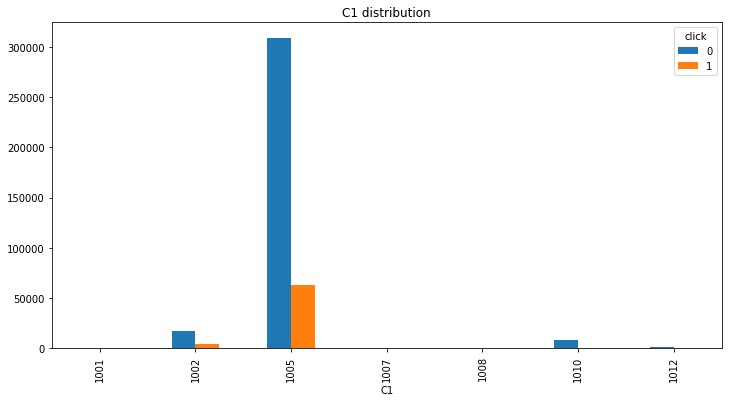

In [153]:
# group C1 with click and plot distribution
df_viz.groupby(['C1', 'click']).size().unstack().plot(kind='bar', figsize=(12,6), title='C1 distribution');

#### Summary:

C1 - 1005 most clicks

### site_category

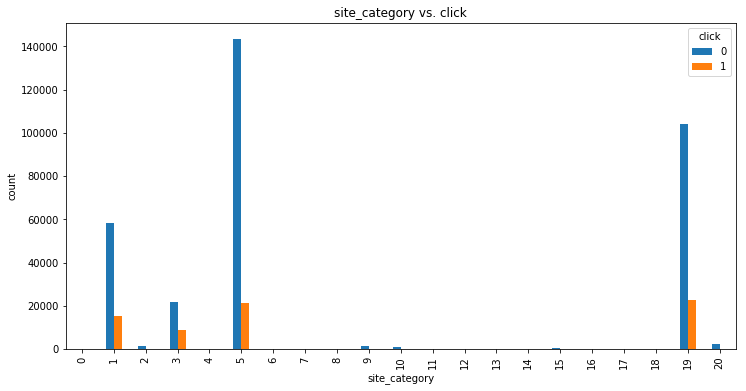

In [154]:
df_viz.groupby(['site_category', 'click']).size().unstack().plot(kind='bar', title="Clicks", figsize=(12,6))
plt.ylabel('count')
plt.title('site_category vs. click');

#### Summary:
highest click activity for site_categories:
 - 1
 - 3
 - 5
 - 19

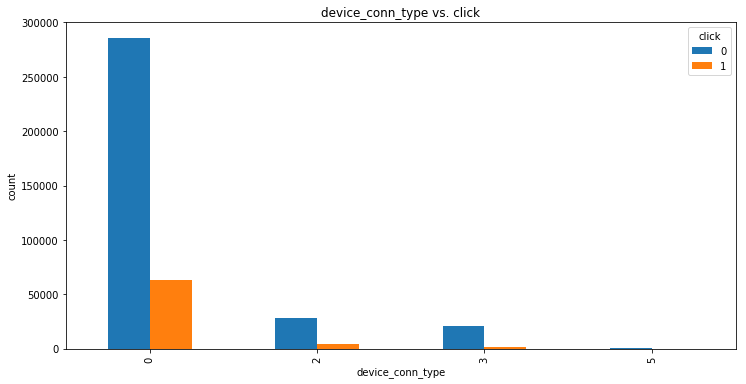

In [155]:
df_dv_conn_type.groupby(['device_conn_type', 'click']).size().unstack().plot(kind='bar', title="Clicks", figsize=(12,6))
plt.ylabel('count')
plt.title('device_conn_type vs. click');

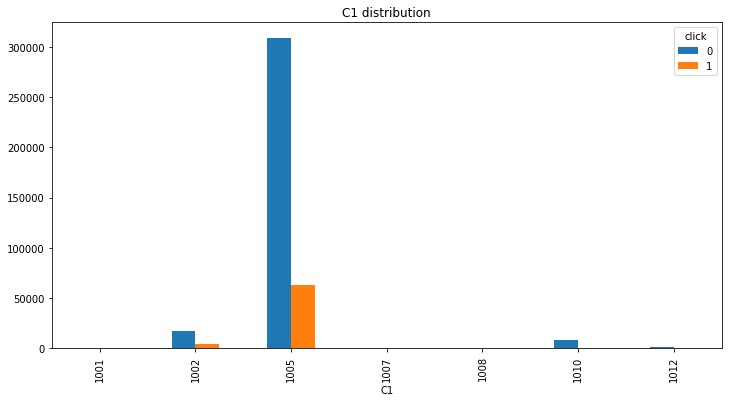

In [156]:
# group C1 with click and plot distribution
df_viz.groupby(['C1', 'click']).size().unstack().plot(kind='bar', figsize=(12,6), title='C1 distribution');

#### Summary:

C1 - 1005 most clicks

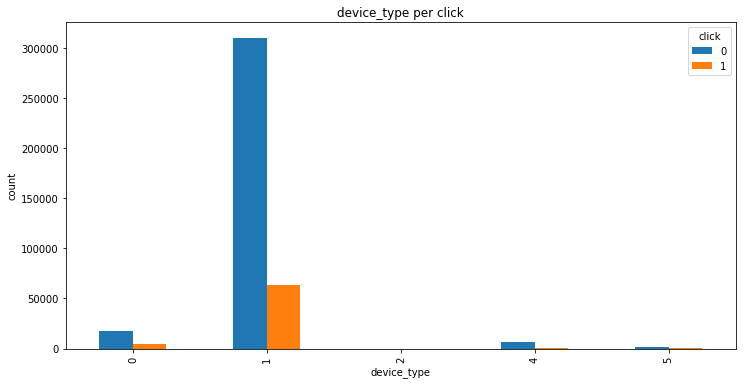

In [157]:
df_viz.groupby(['device_type', 'click']).size().unstack().plot(kind='bar', title="Clicks", figsize=(12,6))
plt.ylabel('count')
plt.title('device_type per click');

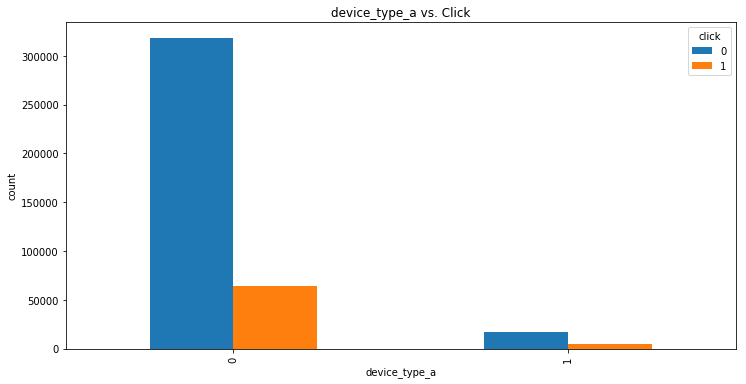

In [158]:
# device_type_a = 0
df_viz.groupby(['device_type_a', 'click']).size().unstack().plot(kind='bar', title="Clicks", figsize=(12,6))
plt.ylabel('count')
plt.title('device_type_a vs. Click');

#### Summary:
Device type A doesn't have a great proportion of click = 1 to click = 0

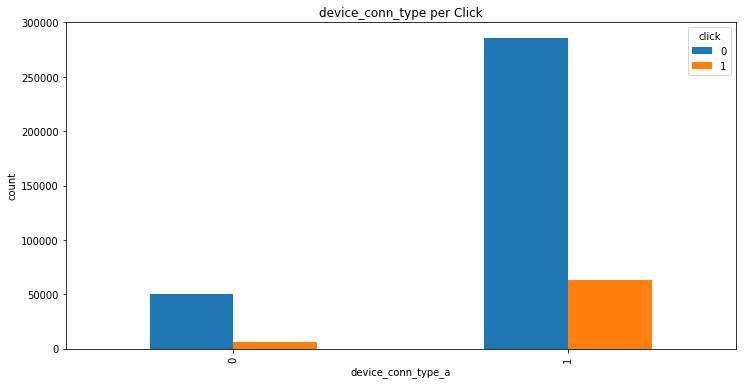

In [159]:
df_viz.groupby(['device_conn_type_a', 'click']).size().unstack().plot(kind='bar', title="Clicks", figsize=(12,6))
plt.ylabel('count')
plt.title('device_conn_type per Click');

In [160]:
# filter for just positive clicks

# check Sams code, he figured out how to deal with NaN.
df_click = df_viz[df_viz.click == 1]

df_click.corr(df_viz.groupby(['device_conn_type', 'click']).size().unstack().plot(kind='bar', title="Clicks", figsize=(12,6))
plt.ylabel('count')
plt.title('device_conn_type per Click');

SyntaxError: invalid syntax (<ipython-input-160-6ee3bb74c81f>, line 7)

Device connection type vs. click

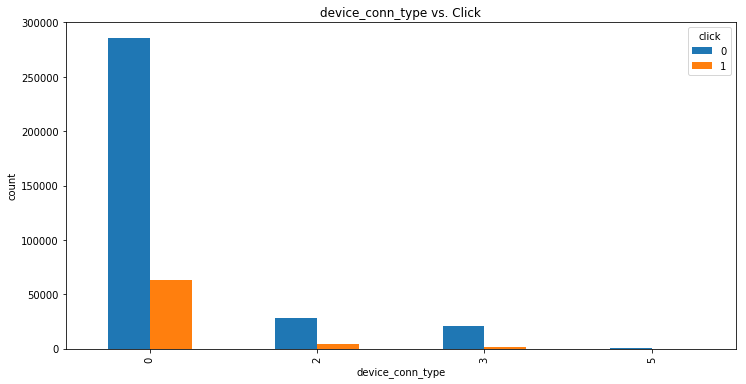

In [161]:
df_viz.groupby(['device_conn_type', 'click']).size().unstack().plot(kind='bar', title="Clicks", figsize=(12,6))
plt.ylabel('count')
plt.title('device_conn_type vs. Click');

#### Summary:
Device type 0 has highest click activity

# Standardize / Normalize Data

In [162]:
# describe means of each column
for col in df_viz.columns:
    mean = df_viz[col].mean()
    print("mean of col: " + str(col) + " is " + str(mean))

# lots of variance here

mean of col: click is 0.16999085086916743
mean of col: C1 is 1004.9673722212606
mean of col: banner_pos is 0.2886377686011721
mean of col: site_id is 1046.65908854875
mean of col: site_domain is 1453.6608763383695
mean of col: site_category is 8.643169061101357
mean of col: app_id is 1847.5357805197696
mean of col: app_domain is 62.23985806483519
mean of col: app_category is 2.9607205558715166
mean of col: device_id is 41269.23497193442
mean of col: device_ip is 131067.57986449395
mean of col: device_model is 2180.5250018545535
mean of col: device_type is 1.0146954823075591
mean of col: device_conn_type is 0.33168813827551247
mean of col: C14 is 18844.936193467027
mean of col: C15 is 318.79585569100664
mean of col: C16 is 60.07658069780668
mean of col: C17 is 2112.733881456937
mean of col: C18 is 1.4314260280408497
mean of col: C19 is 227.8911401795208
mean of col: C20 is 53239.462209144185
mean of col: C21 is 83.30495536707797
mean of col: day_of_week is 2.6012586236739943
mean of col

We ran out of time normalizing our data - again to stick to our gantt chart - our PM pressured enforced our timeline strictly. But normalizing those data is important to model performance!

## Outliers

In [ ]:
# filter out outliers
#df_normal = df_num[np.abs(df_num.Data-df_num.Data.mean()) <= (3*df_num.Data.std())]
# keep only the ones that are within +3 to -3 standard deviations in the column 'Data'.

# keep anything outside of +3 or -3 stdvs
#df_outliers = df_num[~(np.abs(df_num.Data-df_num.Data.mean()) > (3*df_num.Data.std()))]

In [ ]:
# barchart of frequency when a given hashed value appears

We ran out of time controlling outliers of our data - again to stick to our gantt chart - our PM pressured enforced our timeline strictly. But controling outliers could be important to model performance.

## Feature Engineering Continued: 
### Create a user and other groupings

Premise: Bagging vs boosting

"Bagging and Boosting are similar in that they are both ensemble techniques, where a set of weak learners are combined to create a strong learner that obtains better performance than a single one"

"The main causes of error in learning are due to noise, bias and variance"

#### Due to large variance and dimensionality of our features it is a good idea to try bagging/boosting methods

In [168]:
# Sam handled bagging - we latter added it to our 'cleaned' csv - 'choice_features.csv'

### Print csv of transformed data 

In [169]:
df_viz.shape
df_viz.columns
df_viz.dtypes

click                 int64
C1                    int64
banner_pos            int64
site_id               int16
site_domain           int16
site_category          int8
app_id                int16
app_domain            int16
app_category           int8
device_id             int32
device_ip             int32
device_model          int16
device_type           int64
device_conn_type      int64
C14                   int64
C15                   int64
C16                   int64
C17                   int64
C18                   int64
C19                   int64
C20                   int64
C21                   int64
day_of_week           int64
date                   int8
time                   int8
device_type_a         uint8
device_type_b         uint8
device_type_c         uint8
device_type_d         uint8
device_type_e         uint8
device_conn_type_a    uint8
device_conn_type_b    uint8
device_conn_type_c    uint8
device_conn_type_d    uint8
dtype: object

In [170]:
# save to csv to back up work
df_viz.to_csv("numeric_rand_sample.csv")

# Random Forest
## Classification using sklearn
### baseline 

In [ ]:
# baseline random forest
features = ['C1', 'banner_pos', 'site_id', 'site_domain',
       'site_category', 'app_id', 'app_domain', 'app_category', 'device_id',
       'device_ip', 'device_model', 'device_type', 'device_conn_type', 'C14',
       'C15', 'C16', 'C17', 'C18', 'C19', 'C20', 'C21', 'date', 'time', 'device_type_a', 'device_type_b', 'device_type_c', 'device_type_d', 'device_type_e', 'device_conn_type_a', 'device_conn_type_b', 'device_conn_type_c', 'device_conn_type_d']
target = ['click']

X_train, X_test, y_train, y_test = train_test_split(df_viz[features], df_viz[target], test_size = 0.2, random_state = 0)

In [ ]:

#running random forest algorithm

from sklearn.ensemble import RandomForestRegressor

regressor = RandomForestRegressor(n_estimators=100, random_state=0) 
# idk if .ravel is appropriate here, but i'm not even really sure what it does
regressor.fit(X_train, y_train.values.ravel())
y_pred = regressor.predict(X_test)  



In [ ]:
from sklearn import metrics

print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred))) 
